In [7]:
!pip install geopy

     |████████████████████████████████| 113 kB 637 kB/s eta 0:00:01


In [5]:
!pip install geocoder

  Using cached geocoder-1.38.1-py2.py3-none-any.whl (98 kB)
  Using cached ratelim-0.1.6-py2.py3-none-any.whl (4.0 kB)


In [1]:
import pandas as pd
import numpy as np
import requests
#from bs4 import BeautifulSoup
import os
#!conda install -c conda-forge folium=0.5.0 --yes
import folium 
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns

print('Done!')

Done!


In [2]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [3]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [4]:
ny_data.shape

(306, 4)

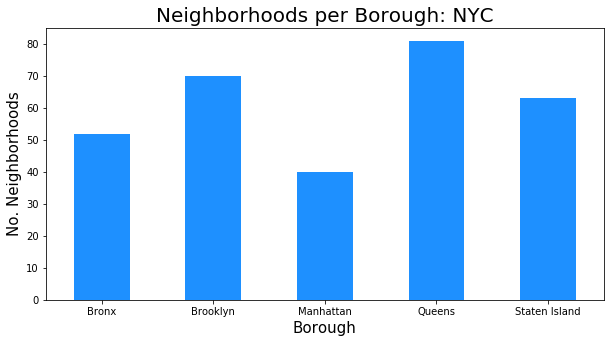

In [5]:
clr = "dodgerblue"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [9]:
# queens has most neighborhoods
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
italian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    italian_resturants=venues[venues['Category']=='Korean Restaurant']   
    print('(',count,'/',len(ny_data),')','Korean Resturants in '+Neighborhood+', '+Borough+':'+str(len(italian_resturants)))
    print(row)
    for resturant_detail in italian_resturants.values.tolist():
        id, name , category=resturant_detail
        italian_rest_ny = italian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Korean Resturants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Korean Resturants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Korean Resturants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Korean Resturants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Korean Resturants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Korean Resturants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Korean Resturants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Korean Resturants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Korean Resturants in Norwood, Bronx:0
['Bronx', 'Norwood',

( 69 / 306 ) Korean Resturants in Gowanus, Brooklyn:0
['Brooklyn', 'Gowanus', 40.673931143187154, -73.99444087145339]
( 70 / 306 ) Korean Resturants in Fort Greene, Brooklyn:0
['Brooklyn', 'Fort Greene', 40.68852726018977, -73.97290574369092]
( 71 / 306 ) Korean Resturants in Park Slope, Brooklyn:0
['Brooklyn', 'Park Slope', 40.67232052268197, -73.97705030183924]
( 72 / 306 ) Korean Resturants in Cypress Hills, Brooklyn:0
['Brooklyn', 'Cypress Hills', 40.68239101144211, -73.87661596457296]
( 73 / 306 ) Korean Resturants in East New York, Brooklyn:0
['Brooklyn', 'East New York', 40.669925700847045, -73.88069863917366]
( 74 / 306 ) Korean Resturants in Starrett City, Brooklyn:0
['Brooklyn', 'Starrett City', 40.64758905230874, -73.87936970045875]
( 75 / 306 ) Korean Resturants in Canarsie, Brooklyn:0
['Brooklyn', 'Canarsie', 40.63556432797428, -73.90209269778966]
( 76 / 306 ) Korean Resturants in Flatlands, Brooklyn:0
['Brooklyn', 'Flatlands', 40.630446043757466, -73.92911302644674]
( 77 

( 133 / 306 ) Korean Resturants in Elmhurst, Queens:0
['Queens', 'Elmhurst', 40.744048505122024, -73.88165622288388]
( 134 / 306 ) Korean Resturants in Howard Beach, Queens:0
['Queens', 'Howard Beach', 40.65422527738487, -73.8381376460028]
( 135 / 306 ) Korean Resturants in Corona, Queens:0
['Queens', 'Corona', 40.74238175015667, -73.85682497345258]
( 136 / 306 ) Korean Resturants in Forest Hills, Queens:0
['Queens', 'Forest Hills', 40.72526378216503, -73.84447500788983]
( 137 / 306 ) Korean Resturants in Kew Gardens, Queens:0
['Queens', 'Kew Gardens', 40.7051790354148, -73.82981905825703]
( 138 / 306 ) Korean Resturants in Richmond Hill, Queens:0
['Queens', 'Richmond Hill', 40.69794731471763, -73.83183321446887]
( 139 / 306 ) Korean Resturants in Flushing, Queens:2
['Queens', 'Flushing', 40.76445419697846, -73.83177300329582]
( 140 / 306 ) Korean Resturants in Long Island City, Queens:0
['Queens', 'Long Island City', 40.75021734610528, -73.93920223915505]
( 141 / 306 ) Korean Resturan

( 200 / 306 ) Korean Resturants in Stapleton, Staten Island:0
['Staten Island', 'Stapleton', 40.62692762538176, -74.07790192660066]
( 201 / 306 ) Korean Resturants in Rosebank, Staten Island:0
['Staten Island', 'Rosebank', 40.61530494652761, -74.06980526716141]
( 202 / 306 ) Korean Resturants in West Brighton, Staten Island:0
['Staten Island', 'West Brighton', 40.63187892654607, -74.1071817826561]
( 203 / 306 ) Korean Resturants in Grymes Hill, Staten Island:0
['Staten Island', 'Grymes Hill', 40.624184791313006, -74.08724819983729]
( 204 / 306 ) Korean Resturants in Todt Hill, Staten Island:0
['Staten Island', 'Todt Hill', 40.59706851814673, -74.1113288180088]
( 205 / 306 ) Korean Resturants in South Beach, Staten Island:0
['Staten Island', 'South Beach', 40.58024741350956, -74.0795529253982]
( 206 / 306 ) Korean Resturants in Port Richmond, Staten Island:0
['Staten Island', 'Port Richmond', 40.63366930554365, -74.12943426797008]
( 207 / 306 ) Korean Resturants in Mariner's Harbor, Sta

( 262 / 306 ) Korean Resturants in Paerdegat Basin, Brooklyn:0
['Brooklyn', 'Paerdegat Basin', 40.63131755039667, -73.90233474295836]
( 263 / 306 ) Korean Resturants in Mill Basin, Brooklyn:0
['Brooklyn', 'Mill Basin', 40.61597423962336, -73.91515391550404]
( 264 / 306 ) Korean Resturants in Jamaica Hills, Queens:0
['Queens', 'Jamaica Hills', 40.71145964370482, -73.79646462081593]
( 265 / 306 ) Korean Resturants in Utopia, Queens:0
['Queens', 'Utopia', 40.73350025429757, -73.79671678028349]
( 266 / 306 ) Korean Resturants in Pomonok, Queens:0
['Queens', 'Pomonok', 40.73493618075478, -73.80486120040537]
( 267 / 306 ) Korean Resturants in Astoria Heights, Queens:0
['Queens', 'Astoria Heights', 40.7703173929982, -73.89467996270574]
( 268 / 306 ) Korean Resturants in Claremont Village, Bronx:0
['Bronx', 'Claremont Village', 40.83142834161548, -73.90119903387667]
( 269 / 306 ) Korean Resturants in Concourse Village, Bronx:0
['Bronx', 'Concourse Village', 40.824780490842905, -73.915846527590

In [7]:
# @hiddel_cell
CLIENT_ID = 'XE2LC10RTCC0NU0G0PWV2K45WKSQBWDRJBHHCNIOXBDJIUFM' # my Foursquare ID
CLIENT_SECRET = 'B5D4S03Y0K10IZV0JATASSWBQKHA1YWJB2KQW4X1W43YPKW0' # my Foursquare Secret
VERSION = '20200530'

In [10]:
italian_rest_ny.to_csv('korean_rest_stats_ny_csvfile.csv') # I continue to save data to a .csv as I move through this project

In [11]:
df_it=italian_rest_ny[['Borough', 'Neighborhood', 'ID','Name']]
df_it.head()
df_it.shape

(51, 4)

In [12]:
df_it = pd.read_csv('korean_rest_stats_ny_csv2.csv')
df_it=italian_rest_ny[['Borough', 'Neighborhood', 'ID','Name']]
df_it.tail()

,Borough,Neighborhood,ID,Name
46,Manhattan,Midtown South,547d03e3498eb32c879589da,Baekjeong NYC (Kang Ho Dong Baekjeong)
47,Manhattan,Midtown South,4bec3943a9900f477abe1840,BonChon Chicken
48,Manhattan,Midtown South,5b857af5b77c77002c2fb242,Hortus
49,Queens,Sunnyside Gardens,4c0c2765a1b32d7f49279cf0,Sik Gaek
50,Queens,Sunnyside Gardens,57ab54da498e7d61e0c1fe0e,Pelicana Chicken


In [13]:
df_it.shape

(51, 4)

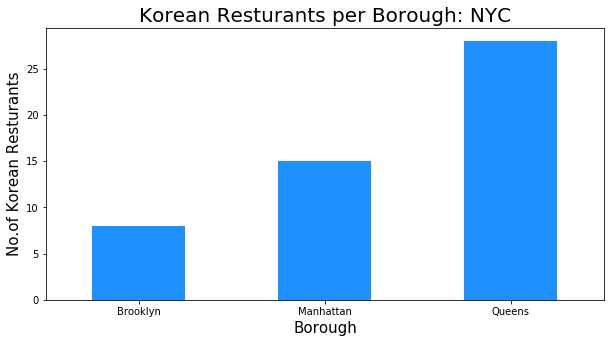

In [14]:
df_it.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color = clr)
plt.title('Korean Resturants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Korean Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

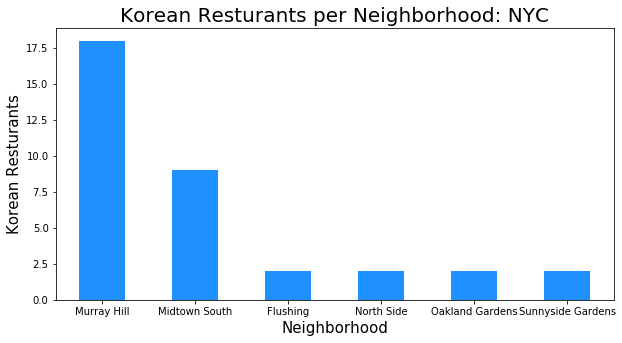

In [15]:
NOofNeigh = 6 # top number for graphing all the same past 6
df_it.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Korean Resturants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Korean Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [16]:
df_it[df_it['Neighborhood']=='Murray Hill']


,Borough,Neighborhood,ID,Name
22,Queens,Murray Hill,4b830e44f964a520ebf430e3,Hahm Ji Bach - 함지박
23,Queens,Murray Hill,4b8f0931f964a520d04533e3,Mapo BBQ
24,Queens,Murray Hill,4c7ad3dda86837048bee144d,Geo Si Gi Restaurant
25,Queens,Murray Hill,4baeabe6f964a52037cd3be3,Kum Sung Chik Naengmyun
26,Queens,Murray Hill,5590598a498eb1c3f975b6a6,Mr. Tofu
27,Queens,Murray Hill,56db53cc498eed9b68621019,SGD Tofu House & BBQ
28,Queens,Murray Hill,4ca67385b7106dcb6e3b5ea5,Bonjuk Korean Traditional Porridge Restaurant
29,Queens,Murray Hill,4ad3bfabf964a52016e620e3,Han Joo
30,Queens,Murray Hill,5cbb9019237dee002cb9f069,Jeong Yook
31,Queens,Murray Hill,5518a1a8498e4c7fe6268b88,Jongro BBQ


In [17]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
italian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in df_it.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(df_it),')','processed')
    italian_rest_stats_ny = italian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
italian_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '5ee10c66be946f5f0858be6c'}, 'response': {'venue': {'id': '4c9d5c0303133704a96f5ed5', 'name': 'Cafe At Your Mother-in-Law', 'contact': {'phone': '7189424088', 'formattedPhone': '(718) 942-4088', 'twitter': 'cafeaymil_ny'}, 'location': {'address': '3071 Brighton 4th St', 'lat': 40.57757524231774, 'lng': -73.96344895612154, 'labeledLatLngs': [{'label': 'display', 'lat': 40.57757524231774, 'lng': -73.96344895612154}, {'label': 'entrance', 'lat': 40.577515, 'lng': -73.963289}], 'postalCode': '11235', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3071 Brighton 4th St', 'Brooklyn, NY 11235', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/cafe-at-your-motherinlaw/4c9d5c0303133704a96f5ed5', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korea

{'meta': {'code': 200, 'requestId': '5ee10c33c6fd9436f6f94b9c'}, 'response': {'venue': {'id': '4fa162e0e4b0badc81404a51', 'name': 'Kimchi Grill', 'contact': {'phone': '7183601839', 'formattedPhone': '(718) 360-1839'}, 'location': {'address': '766 Washington Ave', 'crossStreet': 'btwn Sterling & Park Pl.', 'lat': 40.67512957407338, 'lng': -73.96324476804656, 'labeledLatLngs': [{'label': 'display', 'lat': 40.67512957407338, 'lng': -73.96324476804656}], 'postalCode': '11238', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['766 Washington Ave (btwn Sterling & Park Pl.)', 'Brooklyn, NY 11238', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kimchi-grill/4fa162e0e4b0badc81404a51', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'ver

{'meta': {'code': 200, 'requestId': '5ee10ab6af5ee91de56bbec5'}, 'response': {'venue': {'id': '52bf3053498e754b09a440b5', 'name': 'Dotory', 'contact': {'phone': '7185991399', 'formattedPhone': '(718) 599-1399', 'facebook': '474808822615656', 'facebookUsername': 'dotorybk', 'facebookName': 'Dotory'}, 'location': {'address': '353 Broadway', 'lat': 40.707729602666035, 'lng': -73.95577850789788, 'labeledLatLngs': [{'label': 'display', 'lat': 40.707729602666035, 'lng': -73.95577850789788}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['353 Broadway', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dotory/52bf3053498e754b09a440b5', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'verifi

{'meta': {'code': 200, 'requestId': '5ee10be85159bf15c3f4ecee'}, 'response': {'venue': {'id': '5cf40f14d552c7002c6cc481', 'name': 'Kichin', 'contact': {}, 'location': {'address': '1264 Myrtle Ave', 'crossStreet': 'Cedar Street', 'lat': 40.69770571883561, 'lng': -73.92702341079712, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69770571883561, 'lng': -73.92702341079712}], 'postalCode': '11221', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1264 Myrtle Ave (Cedar Street)', 'Brooklyn, NY 11221', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kichin/5cf40f14d552c7002c6cc481', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 4}, 'url': 'https://www.kichin.nyc', 'price': {'tier': 2, 'mes

{'meta': {'code': 200, 'requestId': '5ee10b2acf9b553d683e19a0'}, 'response': {'venue': {'id': '59c295349b04732c1d51aa52', 'name': 'Kimbap Lab', 'contact': {'phone': '7187342321', 'formattedPhone': '(718) 734-2321'}, 'location': {'address': '238 Bedford Avenue', 'lat': 40.71616, 'lng': -73.95953, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71616, 'lng': -73.95953}], 'postalCode': '11249', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['238 Bedford Avenue', 'Brooklyn, NY 11249', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kimbap-lab/59c295349b04732c1d51aa52', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}, {'id': '56aa371be4b08b9a8d57350b', 'name': 'Food Stand', 'pluralName': 'Food Stands', 'shortName': 'Food Stand', 'i

{'meta': {'code': 200, 'requestId': '5ee10c8036395369197becbd'}, 'response': {'venue': {'id': '43db5698f964a5208a2e1fe3', 'name': 'Dokebi', 'contact': {'phone': '7187821424', 'formattedPhone': '(718) 782-1424', 'twitter': 'dokebibbq'}, 'location': {'address': '199 Grand St', 'crossStreet': 'btwn Bedford & Driggs Ave.', 'lat': 40.714185631114006, 'lng': -73.96033203612464, 'labeledLatLngs': [{'label': 'display', 'lat': 40.714185631114006, 'lng': -73.96033203612464}, {'label': 'entrance', 'lat': 40.714198, 'lng': -73.960309}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['199 Grand St (btwn Bedford & Driggs Ave.)', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dokebi/43db5698f964a5208a2e1fe3', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categ

{'meta': {'code': 200, 'requestId': '5ee10c56f55e2f54f1487790'}, 'response': {'venue': {'id': '52bf3053498e754b09a440b5', 'name': 'Dotory', 'contact': {'phone': '7185991399', 'formattedPhone': '(718) 599-1399', 'facebook': '474808822615656', 'facebookUsername': 'dotorybk', 'facebookName': 'Dotory'}, 'location': {'address': '353 Broadway', 'lat': 40.707729602666035, 'lng': -73.95577850789788, 'labeledLatLngs': [{'label': 'display', 'lat': 40.707729602666035, 'lng': -73.95577850789788}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['353 Broadway', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dotory/52bf3053498e754b09a440b5', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'verifi

{'meta': {'code': 200, 'requestId': '5ee10b77c1ce500e4ec39322'}, 'response': {'venue': {'id': '4b240e1af964a5200a6024e3', 'name': 'Kimchee Korean Cuisine', 'contact': {'phone': '7185675741', 'formattedPhone': '(718) 567-5741'}, 'location': {'address': '9324 3rd Ave', 'crossStreet': 'at 94th St', 'lat': 40.61797065682916, 'lng': -74.03344650023448, 'labeledLatLngs': [{'label': 'display', 'lat': 40.61797065682916, 'lng': -74.03344650023448}, {'label': 'entrance', 'lat': 40.618097, 'lng': -74.033403}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['9324 3rd Ave (at 94th St)', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kimchee-korean-cuisine/4b240e1af964a5200a6024e3', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 's

{'meta': {'code': 200, 'requestId': '5ee10bd50ed92b6704ee2400'}, 'response': {'venue': {'id': '5b4169604a1cc0002c9bdb7c', 'name': 'Grand Seoul', 'contact': {'phone': '2122265555', 'formattedPhone': '(212) 226-5555'}, 'location': {'address': '85 Chrystie St', 'crossStreet': 'Hester Street And Grand Atreet', 'lat': 40.71744683908609, 'lng': -73.99425648068716, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71744683908609, 'lng': -73.99425648068716}], 'postalCode': '10002', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['85 Chrystie St (Hester Street And Grand Atreet)', 'New York, NY 10002', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/grand-seoul/5b4169604a1cc0002c9bdb7c', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'v

{'meta': {'code': 200, 'requestId': '5ee10c28d72a4a1a200d1b6f'}, 'response': {'venue': {'id': '5dbcafa6e40280000819d3db', 'name': 'Kochi', 'contact': {}, 'location': {'address': '652 10th Ave', 'crossStreet': '46th Street', 'lat': 40.76203, 'lng': -73.99355, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76203, 'lng': -73.99355}], 'postalCode': '10036', 'cc': 'US', 'neighborhood': "Hell's Kitchen", 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['652 10th Ave (46th Street)', 'New York, NY 10036', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kochi/5dbcafa6e40280000819d3db', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 4}, 'url': 'http://kochinyc.com', 'price': {'tier': 2, 'message': 'Moderat

{'meta': {'code': 200, 'requestId': '5ee10afa5f782d71691518c2'}, 'response': {'venue': {'id': '5dec54b8f93ca90007806f97', 'name': 'Mokyo', 'contact': {}, 'location': {'address': '109 Saint Marks Pl', 'lat': 40.727179, 'lng': -73.984056, 'labeledLatLngs': [{'label': 'display', 'lat': 40.727179, 'lng': -73.984056}, {'label': 'entrance', 'lat': 40.727122, 'lng': -73.983949}], 'postalCode': '10009', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['109 Saint Marks Pl', 'New York, NY 10009', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/mokyo/5dec54b8f93ca90007806f97', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {

{'meta': {'code': 200, 'requestId': '5ee10c111f420b59214c6b53'}, 'response': {'venue': {'id': '4e67f1c7d16433b90090c8f3', 'name': 'Jungsik', 'contact': {'phone': '2122190900', 'formattedPhone': '(212) 219-0900', 'twitter': 'jungsikdang'}, 'location': {'address': '2 Harrison St', 'crossStreet': 'at Hudson St.', 'lat': 40.718694630954566, 'lng': -74.00906972656956, 'labeledLatLngs': [{'label': 'display', 'lat': 40.718694630954566, 'lng': -74.00906972656956}, {'label': 'entrance', 'lat': 40.718744, 'lng': -74.009072}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2 Harrison St (at Hudson St.)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/jungsik/4e67f1c7d16433b90090c8f3', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean

{'meta': {'code': 200, 'requestId': '5ee10abfede9ed0aedc6c6c7'}, 'response': {'venue': {'id': '59aa0677e17910245d942204', 'name': 'Jeju Noodle Bar', 'contact': {'phone': '2019213333', 'formattedPhone': '(201) 921-3333', 'instagram': 'jejunoodlebar'}, 'location': {'address': '679 Greenwich St', 'crossStreet': 'at Christopher St', 'lat': 40.73294539559912, 'lng': -74.0073655954149, 'labeledLatLngs': [{'label': 'display', 'lat': 40.73294539559912, 'lng': -74.0073655954149}, {'label': 'entrance', 'lat': 40.733036, 'lng': -74.007344}], 'postalCode': '10014', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['679 Greenwich St (at Christopher St)', 'New York, NY 10014', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/jeju-noodle-bar/59aa0677e17910245d942204', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net

{'meta': {'code': 200, 'requestId': '5ee10be7b1a2363762aa2128'}, 'response': {'venue': {'id': '56a14149498e9983c0199038', 'name': 'Mokja', 'contact': {'phone': '6469644296', 'formattedPhone': '(646) 964-4296'}, 'location': {'address': '852 Amsterdam Ave', 'crossStreet': '1010st', 'lat': 40.797706635429854, 'lng': -73.9677888515501, 'labeledLatLngs': [{'label': 'display', 'lat': 40.797706635429854, 'lng': -73.9677888515501}], 'postalCode': '10025', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['852 Amsterdam Ave (1010st)', 'New York, NY 10025', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/mokja/56a14149498e9983c0199038', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'price': {'

{'meta': {'code': 200, 'requestId': '5ee10c16e5ec386ad37dceb0'}, 'response': {'venue': {'id': '4ae39cb6f964a520439721e3', 'name': 'Debasaki', 'contact': {'phone': '7188866878', 'formattedPhone': '(718) 886-6878'}, 'location': {'address': '33-67 Farrington St', 'lat': 40.764851521130126, 'lng': -73.83176733519196, 'labeledLatLngs': [{'label': 'display', 'lat': 40.764851521130126, 'lng': -73.83176733519196}], 'postalCode': '11354', 'cc': 'US', 'city': 'Flushing', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['33-67 Farrington St', 'Flushing, NY 11354', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/debasaki/4ae39cb6f964a520439721e3', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d14c941735', 'name': 'Wings Joint', 'pluralName': 'Wings 

{'meta': {'code': 200, 'requestId': '5ee10c8636395369197c00c8'}, 'response': {'venue': {'id': '4aa5ae46f964a520264920e3', 'name': 'KumGangSan', 'contact': {'phone': '7184610909', 'formattedPhone': '(718) 461-0909'}, 'location': {'address': '13828 Northern Blvd', 'crossStreet': 'btwn Union St & Bowne St', 'lat': 40.763804403940526, 'lng': -73.82714310018443, 'labeledLatLngs': [{'label': 'display', 'lat': 40.763804403940526, 'lng': -73.82714310018443}], 'postalCode': '11354', 'cc': 'US', 'city': 'Flushing', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['13828 Northern Blvd (btwn Union St & Bowne St)', 'Flushing, NY 11354', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kumgangsan/4aa5ae46f964a520264920e3', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'ver

{'meta': {'code': 200, 'requestId': '5ee10b31cf9b553d683e2f66'}, 'response': {'venue': {'id': '58d070dbe309e12fbd02d163', 'name': 'Garlic to the Chicken', 'contact': {}, 'location': {'address': '66-92 Forest Ave', 'crossStreet': 'Putnam Avenue', 'lat': 40.705042, 'lng': -73.90219, 'labeledLatLngs': [{'label': 'display', 'lat': 40.705042, 'lng': -73.90219}], 'postalCode': '11385', 'cc': 'US', 'city': 'Ridgewood', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['66-92 Forest Ave (Putnam Avenue)', 'Ridgewood, NY 11385', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/garlic-to-the-chicken/58d070dbe309e12fbd02d163', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': 

{'meta': {'code': 200, 'requestId': '5ee10b57b5ee8f2175250d12'}, 'response': {'venue': {'id': '4c8425a0d34ca1436d443c80', 'name': 'Ding Dong', 'contact': {'phone': '7182254898', 'formattedPhone': '(718) 225-4898'}, 'location': {'address': '39-23 Bell blBvd', 'lat': 40.76465431727157, 'lng': -73.7715581249102, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76465431727157, 'lng': -73.7715581249102}], 'postalCode': '11361', 'cc': 'US', 'city': 'Bayside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['39-23 Bell blBvd', 'Bayside, NY 11361', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ding-dong/4c8425a0d34ca1436d443c80', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d142941735', 'name': 'Asian Restaurant', 'pluralName': 'Asian Resta

{'meta': {'code': 200, 'requestId': '5ee10b58b5ee8f2175250f29'}, 'response': {'venue': {'id': '4c71ac6dad69b60c49ac81b9', 'name': 'Taeneung', 'contact': {'phone': '7186313636', 'formattedPhone': '(718) 631-3636'}, 'location': {'address': '248-25 northen Blvd', 'lat': 40.767535, 'lng': -73.73851195, 'labeledLatLngs': [{'label': 'display', 'lat': 40.767535, 'lng': -73.73851195}], 'postalCode': '11362', 'cc': 'US', 'city': 'Little Neck', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['248-25 northen Blvd', 'Little Neck, NY 11362', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/taeneung/4c71ac6dad69b60c49ac81b9', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '

{'meta': {'code': 200, 'requestId': '5ee10c537d583140729f0572'}, 'response': {'venue': {'id': '526c1acf11d288dc8354b7b9', 'name': 'Rolly Kimbab', 'contact': {'phone': '3474084172', 'formattedPhone': '(347) 408-4172'}, 'location': {'address': '61-23 Springfield Blvd', 'lat': 40.74853074631299, 'lng': -73.756334784455, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74853074631299, 'lng': -73.756334784455}], 'postalCode': '11364', 'cc': 'US', 'city': 'Bayside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['61-23 Springfield Blvd', 'Bayside, NY 11364', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/rolly-kimbab/526c1acf11d288dc8354b7b9', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 11}, 'url': 'http://rollykimbab

{'meta': {'code': 200, 'requestId': '5ee10bdbcb823607916f5391'}, 'response': {'venue': {'id': '4b830e44f964a520ebf430e3', 'name': 'Hahm Ji Bach - 함지박', 'contact': {'phone': '7184609289', 'formattedPhone': '(718) 460-9289'}, 'location': {'address': '40-11 149th Pl', 'lat': 40.763021787852146, 'lng': -73.81504155699612, 'labeledLatLngs': [{'label': 'display', 'lat': 40.763021787852146, 'lng': -73.81504155699612}], 'postalCode': '11354', 'cc': 'US', 'city': 'Flushing', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['40-11 149th Pl', 'Flushing, NY 11354', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hahm-ji-bach--%ED%95%A8%EC%A7%80%EB%B0%95/4b830e44f964a520ebf430e3', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1df931735', 'name': 'BB

{'meta': {'code': 500, 'errorType': 'server_error', 'errorDetail': 'Foursquare servers are experiencing problems. Please retry and check status.foursquare.com for updates.'}, 'response': {}}


KeyError: 'venue'

In [18]:
italian_rest_stats_ny.to_csv('korean_rest_stats_ny_csv.csv') # I continue to save data to a .csv as I move through this project

In [20]:
italian_rest_stats_ny = pd.read_csv('korean_rest_stats_ny_csv.csv')

In [21]:
italian_rest_stats_ny.shape

(53, 8)

In [22]:
italian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    53 non-null     int64  
 1   Borough       53 non-null     object 
 2   Neighborhood  53 non-null     object 
 3   ID            53 non-null     object 
 4   Name          53 non-null     object 
 5   Likes         53 non-null     int64  
 6   Rating        53 non-null     float64
 7   Tips          53 non-null     int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 3.4+ KB


In [24]:
italian_rest_stats_ny['Likes']=italian_rest_stats_ny['Likes'].astype('float64')
italian_rest_stats_ny['Tips']=italian_rest_stats_ny['Tips'].astype('float64')
italian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    53 non-null     int64  
 1   Borough       53 non-null     object 
 2   Neighborhood  53 non-null     object 
 3   ID            53 non-null     object 
 4   Name          53 non-null     object 
 5   Likes         53 non-null     float64
 6   Rating        53 non-null     float64
 7   Tips          53 non-null     float64
dtypes: float64(3), int64(1), object(4)
memory usage: 3.4+ KB


In [25]:
italian_rest_stats_ny.describe()

,Unnamed: 0,Likes,Rating,Tips
count,53.000000,53.000000,53.000000,53.000000
mean,26.000000,133.169811,7.137736,35.830189
std,15.443445,261.292625,2.172753,59.034454
min,0.000000,0.000000,0.000000,0.000000
25%,13.000000,10.000000,7.100000,4.000000
50%,26.000000,25.000000,7.700000,8.000000
75%,39.000000,108.000000,8.100000,42.000000
max,52.000000,1228.000000,9.000000,284.000000


In [26]:
# Resturant with maximum Likes
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Likes'].idxmax()]

Unnamed: 0                            45
Borough                        Manhattan
Neighborhood               Midtown South
ID              517563f9498e0a4859d08fe4
Name                      BCD Tofu House
Likes                               1228
Rating                               8.7
Tips                                 205
Name: 45, dtype: object

In [27]:
# Resturant with maximum Ratings
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Rating'].idxmax()]

Unnamed: 0                             3
Borough                         Brooklyn
Neighborhood                    Bushwick
ID              5cf40f14d552c7002c6cc481
Name                              Kichin
Likes                                 27
Rating                                 9
Tips                                   4
Name: 3, dtype: object

In [28]:
# Resturant with maximum Tips
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Tips'].idxmax()]

Unnamed: 0                            46
Borough                        Manhattan
Neighborhood               Midtown South
ID              49becfd3f964a520e0541fe3
Name                            Woorijip
Likes                                926
Rating                               7.9
Tips                                 284
Name: 46, dtype: object

In [29]:
ny_neighborhood_stats=italian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
2,Bushwick,9.000000
19,Tribeca,8.600000
11,Midtown South,8.477778
15,Prospect Heights,8.400000
17,South Side,8.400000
21,Williamsburg,8.400000
10,Manhattan Valley,8.100000
6,East Village,7.900000
4,Clinton,7.900000
20,West Village,7.800000


In [30]:
ny_borough_stats=italian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,Manhattan,8.273333
0,Brooklyn,7.900000
2,Queens,6.366667


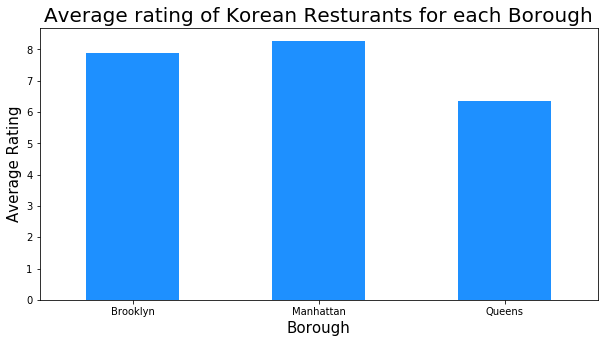

In [38]:
italian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot.bar(figsize=(10,5), color=clr)
plt.title('Average rating of Korean Resturants for each Borough', fontsize=20)
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [32]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
2,Bushwick,9.000000
10,Manhattan Valley,8.100000
11,Midtown South,8.477778
15,Prospect Heights,8.400000
17,South Side,8.400000
19,Tribeca,8.600000
21,Williamsburg,8.400000


In [33]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Bushwick,40.698116,-73.925258,9.000000
1,Manhattan,Manhattan Valley,40.797307,-73.964286,8.100000
2,Manhattan,Midtown South,40.748510,-73.988713,8.477778
3,Brooklyn,Prospect Heights,40.676822,-73.964859,8.400000
4,Brooklyn,South Side,40.710861,-73.958001,8.400000
5,Manhattan,Tribeca,40.721522,-74.010683,8.600000
6,Brooklyn,Williamsburg,40.707144,-73.958115,8.400000


In [34]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()
# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [35]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

In [36]:


ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = 'Borough Boundaries.geojson'
ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)
# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')

/Users/mmahmood/opt/anaconda3/lib/python3.7/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [37]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = r'Borough Boundaries.geojson'
ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='PuBu', #'YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)
# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')